In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")

print("Path to dataset files:", path)

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 11.4M/11.4M [00:01<00:00, 11.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/amananandrai/ag-news-classification-dataset/versions/2


In [3]:
!pip install kagglehub

In [6]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import sklearn
import numpy as np
from torch import Tensor
from einops import rearrange
from typing import Tuple, Callable
from torch.autograd import Function

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

In [8]:
train_data = pd.read_csv(path + '/train.csv')
test_data = pd.read_csv(path + '/test.csv')

In [9]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [10]:
train_data.head()

,Class Index,Title,Description
53541,1,Support independent journalism,Please donate now to our Fall Fund Drive to he...
41728,2,Stingy Falcons Defense Key to 3-0 Start (AP),AP - Maybe the Atlanta Falcons aren't a one-ma...
74819,2,"Pak, Sri Lanka lock horns in Karachi Test today","KARACHI, October 28 (Online): Bruised and batt..."
106459,4,Villages tune in to digital trial,Two villages in Carmarthenshire are the first ...
63062,3,South African gold groups poised for merger,A major re-ordering of South Africa #39;s gold...


In [11]:
print(train_data.shape, val_data.shape, test_data.shape)

(96000, 3) (24000, 3) (7600, 3)


In [13]:
lengths = train_data.Description.str.split().str.len()

In [14]:
print(f"Средняя длина: {lengths.mean():.1f} слов")
print(f"Медиана:        {lengths.median():.0f} слов")
print(f"Минимум:        {lengths.min()} слов")
print(f"Максимум:       {lengths.max()} слов")
print(f"95-й перцентиль: {lengths.quantile(0.95):.0f} слов")
print(f"99-й перцентиль: {lengths.quantile(0.99):.0f} слов")

Средняя длина: 31.1 слов
Медиана:        30 слов
Минимум:        1 слов
Максимум:       173 слов
95-й перцентиль: 45 слов
99-й перцентиль: 63 слов


In [15]:
from collections import Counter

counter = Counter()
for desc in train_data.Description:
    counter.update(desc.split())

In [16]:
max_vocab_size = 9998

In [17]:
most_common_words = counter.most_common(max_vocab_size)

In [18]:
vocab = {'<PAD>': 0, '<UNK>': 1}

for word, _ in most_common_words:
    vocab[word] = len(vocab)

In [20]:
def tokenize_and_pad(text, vocab, max_length=40):
    tokens = [vocab.get(w, vocab['<UNK>']) for w in text.split()]
    return tokens[:max_length] + [vocab['<PAD>']]*(max_length - len(tokens))

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader

class NewsClassification(Dataset):
    def __init__(self, df, vocab, max_length=40):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.max_length = max_length
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        desc = str(self.df.iloc[idx]['Description'])
        label = int(self.df.iloc[idx]['Class Index']) - 1
        input = torch.tensor(tokenize_and_pad(desc, self.vocab, self.max_length), dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)
        return input, label


max_length = 40
train_dataset = NewsClassification(train_data, vocab, max_length=max_length)
val_dataset = NewsClassification(val_data, vocab, max_length=max_length)
test_dataset = NewsClassification(test_data, vocab, max_length=max_length)

In [22]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

96000 24000 7600


In [33]:
batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

In [24]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

def selective_scan(u, delta, A, B, C, D=None, delta_bias=None, delta_softplus=False):
    b, l, d = u.shape
    n = A.shape[1]
    Delta = delta
    if delta_bias is not None:
        Delta = Delta + delta_bias.unsqueeze(0).unsqueeze(0)
    if delta_softplus:
        Delta = F.softplus(Delta)
    A_bar = torch.exp(Delta.unsqueeze(-1) * A.unsqueeze(0).unsqueeze(0))
    B_bar = Delta.unsqueeze(-1) * B.unsqueeze(2)
    h = torch.zeros(b, d, n, device=u.device)
    ys = torch.zeros(b, l, d, device=u.device)
    for i in range(l):
        h = A_bar[:, i] * h + B_bar[:, i] * u[:, i].unsqueeze(-1)
        y = (h * C[:, i].unsqueeze(1)).sum(-1)
        if D is not None:
            y += D * u[:, i]
        ys[:, i] = y
    return ys

class MambaBlock(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.expand = expand
        self.d_inner = int(self.expand * self.d_model)
        self.dt_rank = math.ceil(self.d_model / 16)

        self.in_proj = nn.Linear(self.d_model, self.d_inner * 2, bias=False)
        self.conv1d = nn.Conv1d(self.d_inner, self.d_inner, kernel_size=self.d_conv, bias=True, groups=self.d_inner, padding=self.d_conv - 1)
        self.act = nn.SiLU()
        self.x_proj = nn.Linear(self.d_inner, self.dt_rank + self.d_state * 2, bias=False)
        self.dt_proj = nn.Linear(self.dt_rank, self.d_inner, bias=True)

        dt_init_std = self.dt_rank ** -0.5
        nn.init.uniform_(self.dt_proj.weight, -dt_init_std, dt_init_std)
        dt = torch.exp(torch.rand(self.d_inner) * (math.log(0.1) - math.log(0.001)) + math.log(0.001))
        self.dt_proj.bias.data = torch.log(dt + 1e-5)

        A = torch.arange(1, self.d_state + 1, dtype=torch.float32).repeat(self.d_inner, 1)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(self.d_inner))
        self.out_proj = nn.Linear(self.d_inner, self.d_model, bias=False)

    def forward(self, x):
        b, l, d = x.shape

        x_and_res = self.in_proj(x)
        x, res = x_and_res.chunk(2, dim=-1)

        x = x.permute(0, 2, 1)
        x = self.conv1d(x)[:, :, :l]
        x = x.permute(0, 2, 1)
        x = self.act(x)

        x_db = self.x_proj(x)
        dt, B, C = torch.split(x_db, [self.dt_rank, self.d_state, self.d_state], dim=-1)
        dt = self.dt_proj(dt)

        A = -torch.exp(self.A_log)
        y = selective_scan(x, dt, A, B, C, self.D, delta_softplus=True)

        y = y * self.act(res)
        y = self.out_proj(y)
        return y

class MambaClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int = 40,
        num_classes: int = 4,
        num_hidden_layers: int = 6,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.1)

        self.mamba_layers = nn.Sequential(*[
            MambaBlock(d_model=embedding_dim, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(num_hidden_layers)
        ])
        self.norm = nn.LayerNorm(embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = self.dropout(x)
        x = self.mamba_layers(x)

        last_token_hidden = x[:, -1, :]
        normalized = self.norm(last_token_hidden)
        normalized = self.dropout(normalized)
        logits = self.classifier(normalized)
        return logits

In [26]:
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 53.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [transformers] [transformers]ub]


In [80]:
from tqdm import tqdm
from transformers import get_cosine_schedule_with_warmup


embedding_dim = 64
vocab_size = len(vocab)
num_classes = 4
num_layers = 1


model = MambaClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    num_classes=num_classes,
    num_hidden_layers=num_layers,
    d_state=16,
    d_conv=4,
    expand=2
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=0.01)
num_epochs = 20
total_steps = num_epochs * len(train_loader)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

In [ ]:
import wandb

wandb.init(
    project="Text Classification",
    config={
        "learning_rate": 1e-3,
        "batch_size": 1024,
        "dataset": "ag-news-classification-dataset",
    }
)

epoch,▁▃▆█
train/loss,█▅▄▁
train/lr,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇█████
val/accuracy,▁▂▇█
val/loss,█▆▅▁
epoch,4
train/loss,1.38686
train/lr,0.0003
val/accuracy,0.28167
val/loss,1.3808


In [28]:
def validate(model, criterion, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
      for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        logits = model(inputs)
        loss = criterion(logits, labels)
        val_loss+=loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_val_loss = val_loss/len(val_loader)
    accuracy = correct / total
    return avg_val_loss, accuracy


In [30]:
def train_one_epoch(model, criterion, optimizer, scheduler, train_loader, device):
    model.train()
    train_loss = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        # wandb.log({"train/lr": scheduler.get_last_lr()[0],})
        optimizer.step()
        scheduler.step()
        train_loss+=loss.item()

    avg_train_loss = train_loss/len(train_loader)
    return avg_train_loss

In [31]:
def train(model, optimizer, scheduler, criterion, num_epochs, train_loader, val_loader, device):
    best_loss = np.inf
    patience_step = 0
    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, criterion, optimizer, scheduler, train_loader, device)
        val_loss, accuracy = validate(model, criterion, val_loader)
        print(f"Epoch: {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        # wandb.log({
        #     "train/loss": train_loss,
        #     "val/accuracy": accuracy,
        #     "epoch": epoch,
        #     "val/loss": val_loss
        # })
        if val_loss < best_loss:
            best_loss = val_loss
            patience_step = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_step += 1


In [81]:
train(model, optimizer, scheduler, criterion, num_epochs, train_loader, val_loader, device)

100%|██████████| 12/12 [00:01<00:00,  8.19it/s]


Epoch: 1/20, Train Loss: 1.4263, Val Loss: 1.3929


100%|██████████| 12/12 [00:01<00:00,  8.22it/s]


Epoch: 2/20, Train Loss: 1.3964, Val Loss: 1.3857


100%|██████████| 12/12 [00:01<00:00,  9.53it/s]


Epoch: 3/20, Train Loss: 1.3803, Val Loss: 1.3429


100%|██████████| 12/12 [00:01<00:00,  9.53it/s]


Epoch: 4/20, Train Loss: 1.1858, Val Loss: 1.0036


100%|██████████| 12/12 [00:01<00:00,  9.74it/s]


Epoch: 5/20, Train Loss: 0.9163, Val Loss: 0.7985


100%|██████████| 12/12 [00:01<00:00,  9.72it/s]


Epoch: 6/20, Train Loss: 0.7576, Val Loss: 0.6811


100%|██████████| 12/12 [00:01<00:00,  9.57it/s]


Epoch: 7/20, Train Loss: 0.6585, Val Loss: 0.6109


100%|██████████| 12/12 [00:01<00:00,  8.22it/s]


Epoch: 8/20, Train Loss: 0.5942, Val Loss: 0.5600


100%|██████████| 12/12 [00:01<00:00,  9.58it/s]


Epoch: 9/20, Train Loss: 0.5469, Val Loss: 0.5263


100%|██████████| 12/12 [00:01<00:00,  9.54it/s]


Epoch: 10/20, Train Loss: 0.5135, Val Loss: 0.5001


100%|██████████| 12/12 [00:01<00:00,  9.60it/s]


Epoch: 11/20, Train Loss: 0.4879, Val Loss: 0.4822


100%|██████████| 12/12 [00:01<00:00,  9.74it/s]


Epoch: 12/20, Train Loss: 0.4678, Val Loss: 0.4685


100%|██████████| 12/12 [00:01<00:00,  9.52it/s]


Epoch: 13/20, Train Loss: 0.4532, Val Loss: 0.4583


100%|██████████| 12/12 [00:01<00:00,  9.79it/s]


Epoch: 14/20, Train Loss: 0.4430, Val Loss: 0.4513


100%|██████████| 12/12 [00:01<00:00,  9.60it/s]


Epoch: 15/20, Train Loss: 0.4330, Val Loss: 0.4459


100%|██████████| 12/12 [00:01<00:00,  8.40it/s]


Epoch: 16/20, Train Loss: 0.4282, Val Loss: 0.4424


100%|██████████| 12/12 [00:01<00:00,  9.57it/s]


Epoch: 17/20, Train Loss: 0.4234, Val Loss: 0.4403


100%|██████████| 12/12 [00:01<00:00,  9.69it/s]


Epoch: 18/20, Train Loss: 0.4212, Val Loss: 0.4394


100%|██████████| 12/12 [00:01<00:00,  9.80it/s]


Epoch: 19/20, Train Loss: 0.4210, Val Loss: 0.4390


100%|██████████| 12/12 [00:01<00:00,  9.82it/s]

Epoch: 20/20, Train Loss: 0.4195, Val Loss: 0.4389


tensor([[  38,    9,   36,   55, 8468,   20,    4,    1, 5352,   18,    2,  532,
            5, 6851,  170,    4, 7142,    3, 1215,    4, 7315,    5, 3754,  577,
            1,   68,   32,  928, 9369,    5,    1,    1,    2, 1139, 6145,    5,
            1,    0,    0,    0]], device='cuda:0')


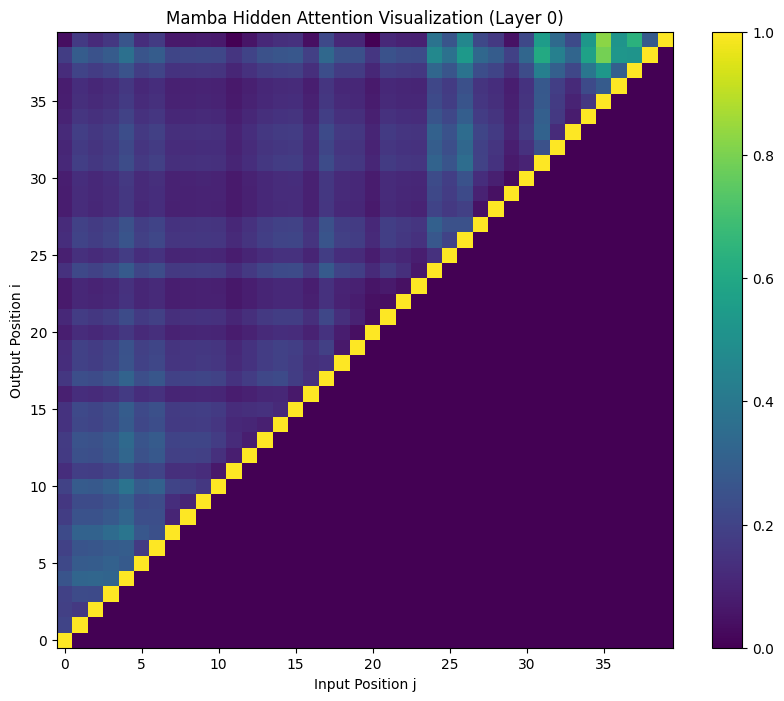

In [85]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

input_ids = test_dataset[2][0].unsqueeze(0).to(device)
print(input_ids)

model.eval()
with torch.no_grad():
    emb = model.embedding(input_ids)
    x = model.dropout(emb)

    layer_idx = 0
    block = model.mamba_layers[layer_idx]

    b, l, d_model = x.shape
    x_and_res = block.in_proj(x)
    xx, res = x_and_res.chunk(2, dim=-1)

    xx = xx.permute(0, 2, 1)
    xx = block.conv1d(xx)[:, :, :l]
    xx = xx.permute(0, 2, 1)
    xx = block.act(xx)

    x_db = block.x_proj(xx)
    dt, B, C = torch.split(x_db, [block.dt_rank, block.d_state, block.d_state], dim=-1)
    dt = block.dt_proj(dt)

    A = -torch.exp(block.A_log)

    Delta = F.softplus(dt)
    A_bar = torch.exp(Delta.unsqueeze(-1) * A.unsqueeze(0).unsqueeze(0))
    B_bar = Delta.unsqueeze(-1) * B.unsqueeze(2)

    D = block.D

    device = x.device
    d_inner, n = A.shape

    log_A_bar = torch.log(A_bar[0])
    zeros = torch.zeros(1, d_inner, n, device=device)
    cum_log = torch.cumsum(log_A_bar, dim=0)
    prefix = torch.cat([zeros, cum_log], dim=0)

    i_idx = torch.arange(l, device=device).view(-1, 1).expand(l, l)
    j_idx = torch.arange(l, device=device).view(1, -1).expand(l, l)

    prod_log = prefix[i_idx + 1] - prefix[j_idx + 1]
    prod = torch.exp(prod_log)

    B_bar_j = B_bar[0][j_idx]
    C_i = C[0][i_idx]

    weights_per_d_s = prod * B_bar_j * C_i.unsqueeze(2)
    alpha_per_d = weights_per_d_s.sum(dim=3)

    diag_idx = torch.arange(l, device=device)
    alpha_per_d[diag_idx, diag_idx, :] += D

    alpha = torch.abs(alpha_per_d).mean(dim=2)

    mask = (j_idx <= i_idx).float()
    alpha = alpha * mask

    for i in range(l):
        row = alpha[i]
        min_val = row.min()
        max_val = row.max()
        if max_val > min_val:
            alpha[i] = (row - min_val) / (max_val - min_val + 1e-16)

plt.figure(figsize=(10, 8))
plt.imshow(alpha.cpu().numpy(), cmap='viridis', origin='lower')
plt.xlabel('Input Position j')
plt.ylabel('Output Position i')
plt.colorbar()
plt.title(f'Mamba Hidden Attention Visualization (Layer {layer_idx})')
plt.show()


Это по сути матрица влияния входных токенов на скрытые состояния модели. Тут мы можем видеть, какие токены влияют на скрытое состояние в текущий момент сильнее всего. Как мы можем видеть, на текущее состояние сильнее всего влияет текущий входной токен. Так же некоторые входные токены на протяжении всего времени влияют на скрытое состояние(вертикальные полосы), а некоторые вообще не влияют. Это говорит о том, что модель при предсказании опирается на ключевые сло

In [83]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            preds = logits.argmax(dim=1)  # для многоклассовой классификации
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy


In [84]:
val_acc = compute_accuracy(model, val_loader, device)
test_acc = compute_accuracy(model, test_loader, device)

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Validation Accuracy: 0.8407
Test Accuracy: 0.8295
